<a href="https://colab.research.google.com/github/jainmridul82/Neural-Networks/blob/main/GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import opendatasets as od
download_url="https://www.kaggle.com/splcher/animefacedataset"
od.download(download_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: jainmridul
Your Kaggle Key: ··········


  5%|▌         | 21.0M/395M [00:00<00:01, 215MB/s]

100%|██████████| 395M/395M [00:01<00:00, 216MB/s]


In [ ]:
import os

DATA_DIR="/content/animefacedataset"
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+"/images"))

['61422_2018.jpg', '31445_2010.jpg', '55156_2016.jpg', '21013_2008.jpg', '62363_2019.jpg', '55836_2017.jpg', '44501_2013.jpg', '26055_2009.jpg', '29096_2010.jpg', '5363_2003.jpg', '30889_2010.jpg', '7824_2004.jpg', '47326_2014.jpg', '46494_2014.jpg', '13235_2005.jpg', '30488_2010.jpg', '23103_2008.jpg', '61621_2018.jpg', '5253_2003.jpg', '47569_2014.jpg', '28749_2010.jpg', '58659_2017.jpg', '5244_2003.jpg', '8577_2004.jpg', '2758_2002.jpg', '32487_2011.jpg', '49475_2015.jpg', '53035_2016.jpg', '24028_2008.jpg', '44116_2013.jpg', '25898_2009.jpg', '30312_2010.jpg', '44486_2013.jpg', '42703_2013.jpg', '51505_2015.jpg', '54683_2016.jpg', '56077_2017.jpg', '60763_2018.jpg', '48095_2014.jpg', '12948_2005.jpg', '41612_2013.jpg', '40436_2012.jpg', '27988_2009.jpg', '16357_2006.jpg', '35966_2011.jpg', '24658_2009.jpg', '56454_2017.jpg', '15422_2006.jpg', '11229_2005.jpg', '7694_2004.jpg', '16731_2007.jpg', '37421_2012.jpg', '25966_2009.jpg', '26989_2009.jpg', '41044_2013.jpg', '8482_2004.jpg',

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams["figure.facecolor"]="white"

In [ ]:
image_size=64
batch_size=128
stats=(0.5,0.5,0.5),(0.5,0.5,0.5)

In [ ]:
train_ds=torchvision.datasets.ImageFolder(DATA_DIR,transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Resize(image_size),
        torchvision.transforms.Normalize(*stats,inplace=True),
        torchvision.transforms.CenterCrop(image_size)
]))
train_dataloader=torch.utils.data.DataLoader(train_ds,batch_size,shuffle=True,num_workers=3,pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def denormalize(images,device,mean,std):
    mean=torch.tensor(mean,device=device).reshape(1,3,1,1)
    std=torch.tensor(std,device=device).reshape(1,3,1,1)
    images=images.to(device)
    return images*std+mean

In [ ]:
def show_batch(dataloader,nmax=64):
    for images,_ in dataloader:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([])
        ax.set_yticks([])
        denorm=denormalize(images[:nmax],device,*stats)
        X=torchvision.utils.make_grid(denorm,nrow=8)
        ax.imshow(X.detach().cpu().permute(1,2,0))
        break

In [ ]:
def get_default_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    return torch.device("cuda")

In [ ]:
device=get_default_device()
print(device)

cuda


In [ ]:
def to_device(data,device):
    if isinstance(data,(list,tuple)):
        return [to_device(x,device) for x in data]
    return data.to(device,non_blocking=True)

In [ ]:
class DeviceDataLoader:
    def __init__(self,data,device):
        self.data=data
        self.device=device
    def __len__(self):
        return len(self.data)
    def __iter__(self):
        for x in self.data:
            yield to_device(x,self.device)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


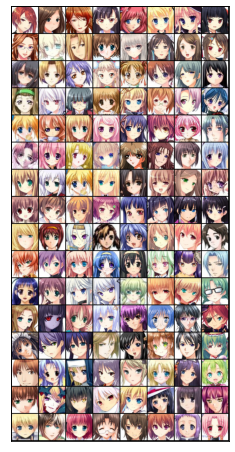

In [ ]:
show_batch(train_dataloader,128)

In [ ]:
train_loader=DeviceDataLoader(train_dataloader,device)

In [ ]:
discriminator=torch.nn.Sequential(
    torch.nn.Conv2d(3,64,kernel_size=4,padding=1,stride=2,bias=False), # (128,3,64,64)->(128,64,32,32)
    torch.nn.BatchNorm2d(64),
    torch.nn.LeakyReLU(0.2,inplace=True),

    torch.nn.Conv2d(64,128,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.LeakyReLU(0.2,inplace=True),

    torch.nn.Conv2d(128,256,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.LeakyReLU(0.2,inplace=True),

    torch.nn.Conv2d(256,512,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.LeakyReLU(0.2,inplace=True),

    torch.nn.Conv2d(512,1,kernel_size=4,padding=0,stride=1,bias=False),
    torch.nn.Flatten(),
    torch.nn.Sigmoid()
)

In [ ]:
discriminator=to_device(discriminator,device)

In [ ]:
latent_size=128

In [ ]:
generator=torch.nn.Sequential(
    torch.nn.ConvTranspose2d(latent_size,512,kernel_size=4,padding=0,stride=1,bias=False),
    torch.nn.BatchNorm2d(512),
    torch.nn.ReLU(inplace=True), # (512,4,4)

    torch.nn.ConvTranspose2d(512,256,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(256),
    torch.nn.ReLU(inplace=True), # (256,8,8)

    torch.nn.ConvTranspose2d(256,128,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(128),
    torch.nn.ReLU(inplace=True), # (128,16,16)

    torch.nn.ConvTranspose2d(128,64,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.BatchNorm2d(64),
    torch.nn.ReLU(inplace=True), # (64,32,32)

    torch.nn.ConvTranspose2d(64,3,kernel_size=4,padding=1,stride=2,bias=False),
    torch.nn.Tanh() # (3,64,64)
)

In [ ]:
def show_images(images):
    fig,ax=plt.subplots(figsize=(14,14))
    ax.set_xticks([])
    ax.set_yticks([])
    denorm=denormalize(images,device,*stats)
    X=torchvision.utils.make_grid(denorm,nrow=8)
    ax.imshow(X.detach().cpu().permute(1,2,0))

torch.Size([128, 3, 64, 64])


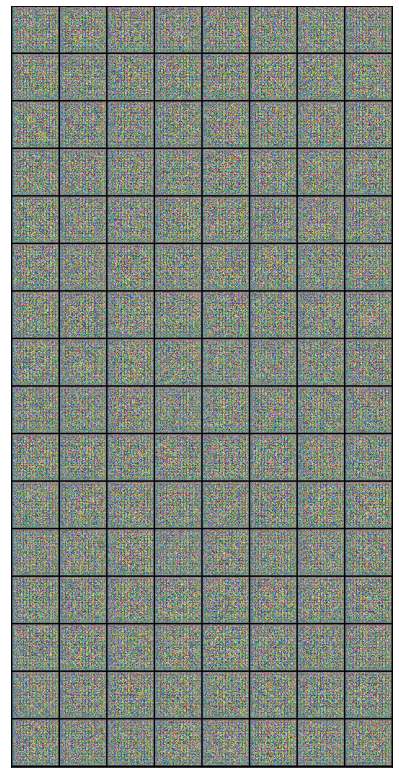

In [ ]:
images=torch.randn(batch_size,latent_size,1,1)
fake_images=generator(images)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator=to_device(generator,device)

In [ ]:
images1=torch.randn(100,3,64,64)
images1=to_device(images1,device)
print(images1.shape)
out=discriminator(images1)
print(out.shape)

torch.Size([100, 3, 64, 64])
torch.Size([100, 1])


In [ ]:
def train_discriminator(real_imgs,opt_d):
    opt_d.zero_grad()
    real_preds=discriminator(real_imgs)
    real_targets=torch.ones(real_imgs.size(0),1,device=device)
    real_loss=torch.nn.functional.binary_cross_entropy(real_preds,real_targets)
    real_score=torch.mean(real_preds).item()

    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)

    fake_preds=discriminator(fake_images)
    fake_targets=torch.zeros(fake_images.size(0),1,device=device)
    fake_loss=torch.nn.functional.binary_cross_entropy(fake_preds,fake_targets)
    fake_score=torch.mean(fake_preds).item()

    loss=real_loss+fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(),real_score,fake_score

In [ ]:
def train_generator(opt_g):
    opt_g.zero_grad()
    latent=torch.randn(batch_size,latent_size,1,1,device=device)
    fake_images=generator(latent)
    preds=discriminator(fake_images)
    targets=torch.ones(batch_size,1,device=device)
    loss=torch.nn.functional.binary_cross_entropy(preds,targets)
    loss.backward()
    opt_g.step()
    return loss.item()

In [ ]:
import os

In [ ]:
sample_dir="generated-new-latest"
os.makedirs(sample_dir,exist_ok=True)

In [ ]:
fixed_latent=torch.randn(64,latent_size,1,1,device=device)

In [ ]:
def save_examples(index,latent_tensors,device,show=True):
    fake_images=generator(latent_tensors)
    fake_fname="generated-images-{0:0=4d}.png".format(index)
    torchvision.utils.save_image(denormalize(fake_images,device,*stats),os.path.join(sample_dir,fake_fname),nrow=8)
    print('Saving',fake_fname)
    if show:
        fig,ax=plt.subplots(figsize=(8,8))
        ax.set_xticks([]); ax.set_yticks([])
        X=torchvision.utils.make_grid(fake_images.cpu().detach(),nrow=8)
        ax.imshow(X.permute(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


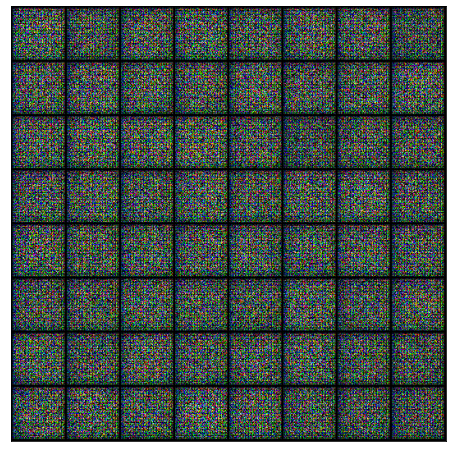

In [ ]:
save_examples(0,fixed_latent,device=device)

In [ ]:
import tqdm

In [ ]:
def fit(epochs,lr,start_idx=1):
    torch.cuda.empty_cache()
    losses_g=[]
    losses_d=[]
    real_scores=[]
    fake_scores=[]
    opt_g=torch.optim.Adam(generator.parameters(),lr=lr,betas=(0.5,0.9999))
    opt_d=torch.optim.Adam(discriminator.parameters(),lr=lr,betas=(0.5,0.9999))
    for epoch in range(epochs):
        for real_imgs,_ in tqdm.notebook.tqdm(train_loader):
            loss_d,real_score,fake_score=train_discriminator(real_imgs,opt_d)
            loss_g=train_generator(opt_g)
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1,epochs,loss_g,loss_d,real_score,fake_score))
        save_examples(epoch+start_idx,fixed_latent,device,show=False)
    return losses_g,losses_d,real_scores,fake_scores

In [ ]:
epochs=3
lr=0.0002

In [ ]:
history=fit(epochs,lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/3], loss_g: 4.6594, loss_d: 0.8442, real_score: 0.5378, fake_score: 0.0130
Saving generated-images-0001.png



Epoch [2/3], loss_g: 5.5428, loss_d: 0.4316, real_score: 0.7205, fake_score: 0.0173
Saving generated-images-0002.png



Epoch [3/3], loss_g: 2.2972, loss_d: 0.2931, real_score: 0.8552, fake_score: 0.0976
Saving generated-images-0003.png


In [ ]:
import IPython

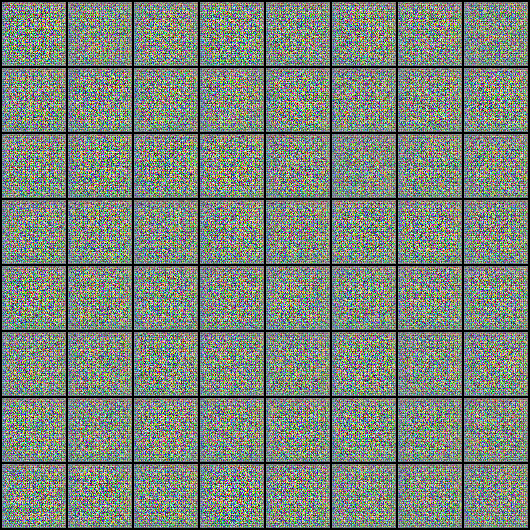

In [ ]:
IPython.display.Image("/content/generated-new-latest/generated-images-0000.png")

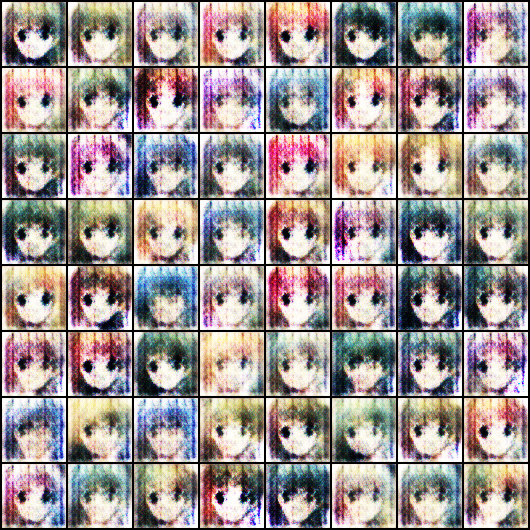

In [ ]:
IPython.display.Image("/content/generated-new-latest/generated-images-0001.png")

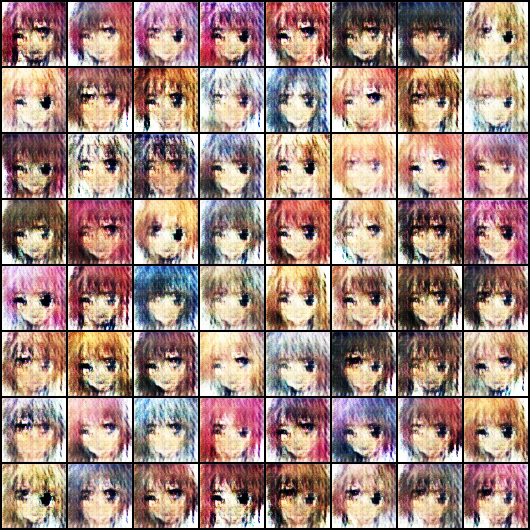

In [ ]:
IPython.display.Image("/content/generated-new-latest/generated-images-0002.png")

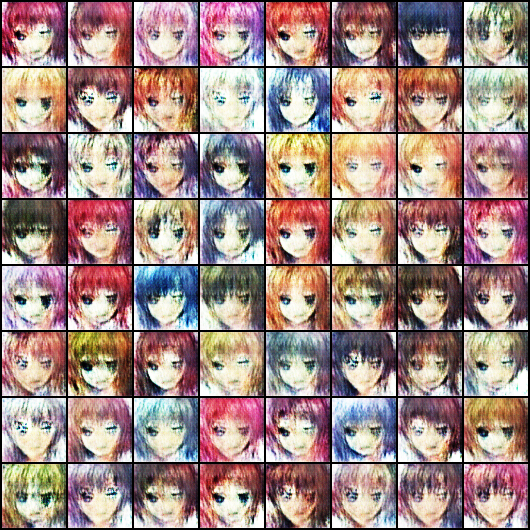

In [ ]:
IPython.display.Image("/content/generated-new-latest/generated-images-0003.png")

In [ ]:
import cv2
import os

In [ ]:
vid_fname="gans_training.avi"
files=[os.path.join(sample_dir,f) for f in os.listdir(sample_dir) if "generated" in f]
files.sort()
out=cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*"MP4V"),1,(530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

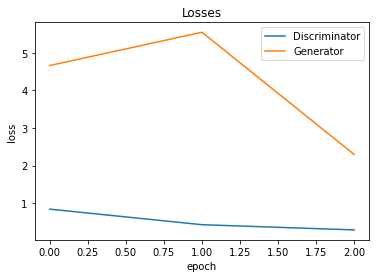

In [ ]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

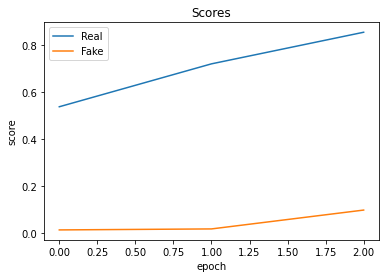

In [ ]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');